# Implementing and comparing LRP techniques

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
from relevancecmp import compare_relevance

## 0. Load datset

In [4]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [7]:
device = torch.device('mps')

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [9]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [25]:
# Build the model
inputs = 784
hidden1 = 17*17
hidden2 = 10*10
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [26]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35652 | Test loss: 0.14020, Test acc: 95.91%


## 2. Layer-wise Relevance Propagation

### 2.0 Preparing for LRP

In [27]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L

3

In [28]:
X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

In [29]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

### 2.1 Actual LRP

In [30]:
nb_digits = len(train.classes)
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

General rule for the hidden and output layers:
$$R_j = \sum_k \frac{a_j \rho(w_{jk})}{\epsilon + \sum_{0,j} a_j \rho(w_{jk})} R_k$$

In [31]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

Four steps of computing the relevance:
$$
\begin{align*}
\forall k:~z_k &= {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall k:~s_k &= R_k / z_k \qquad & (\text{step }2)\\
\forall j:~c_j &= {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall j:~R_j &= a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
$$

In [32]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

$z^\mathcal{B}$ rule for the input layer:
$$R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j$$

In [33]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

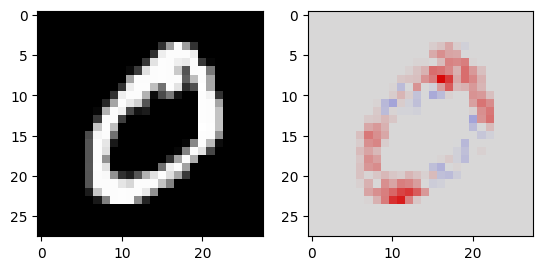

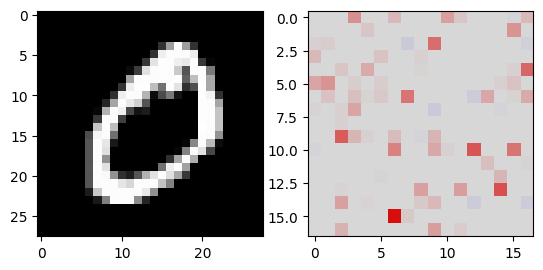

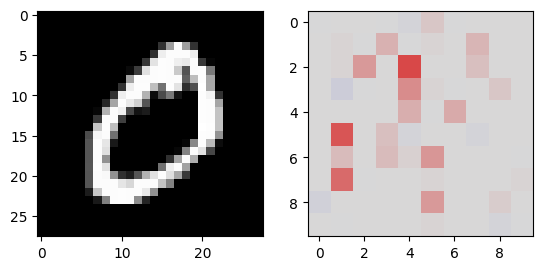

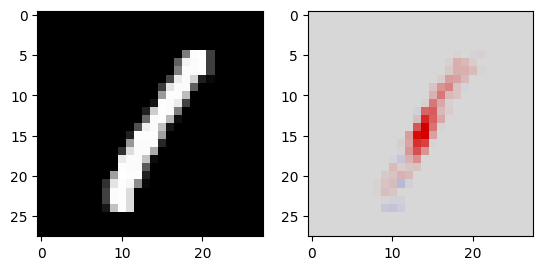

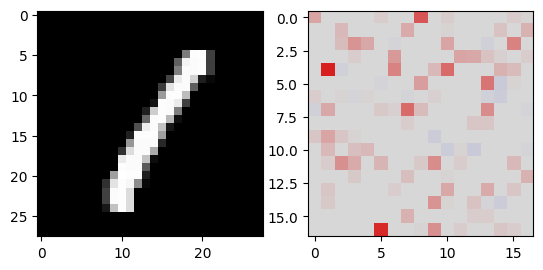

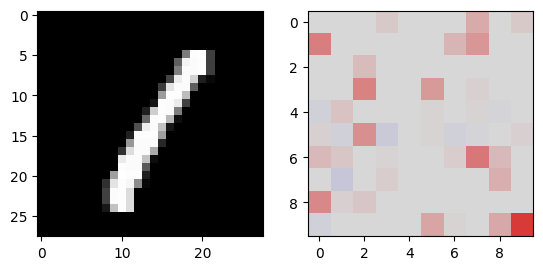

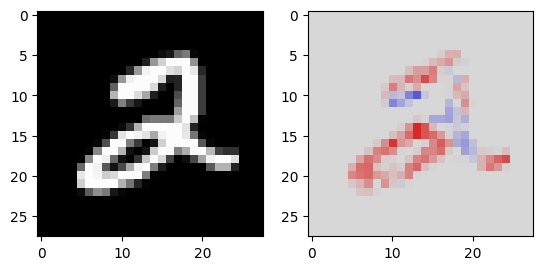

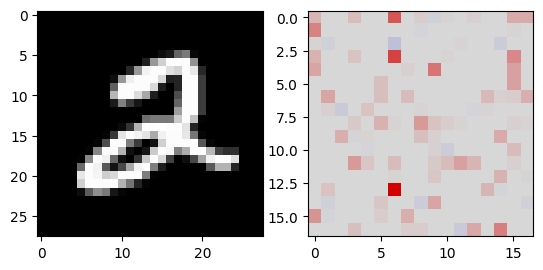

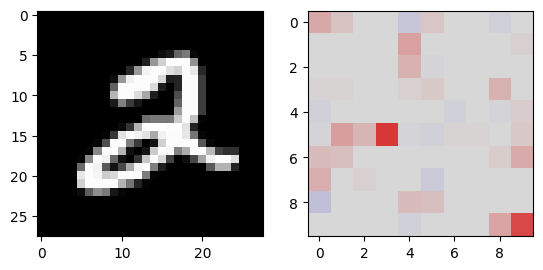

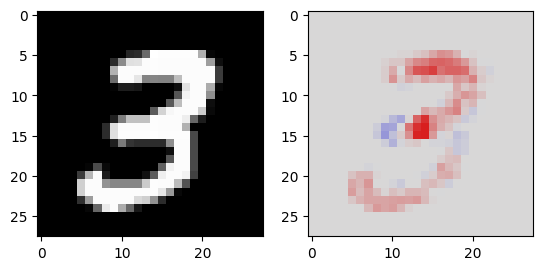

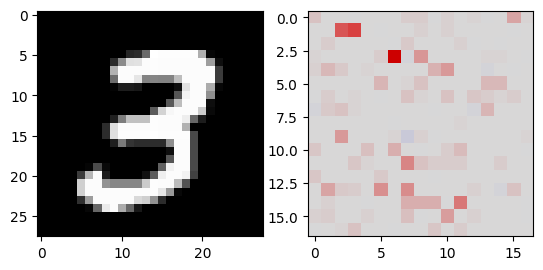

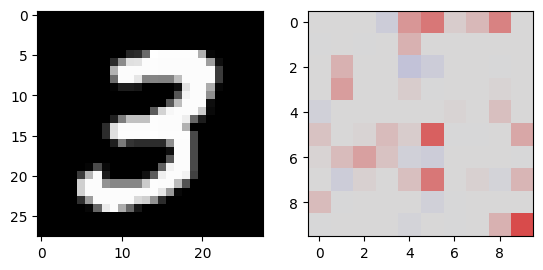

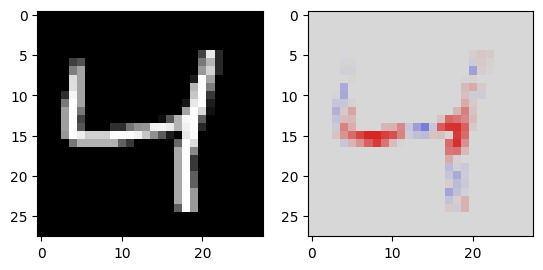

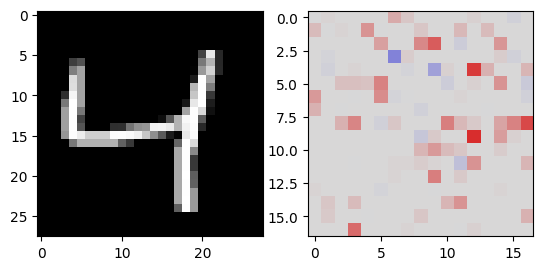

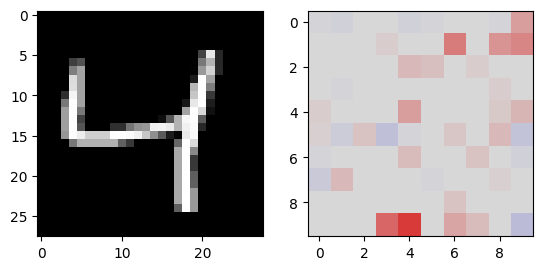

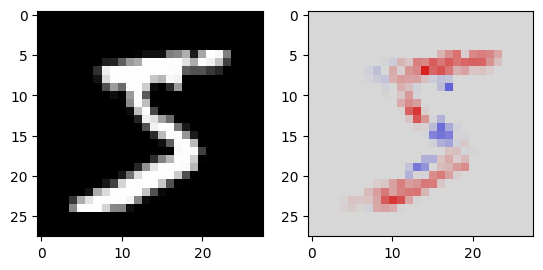

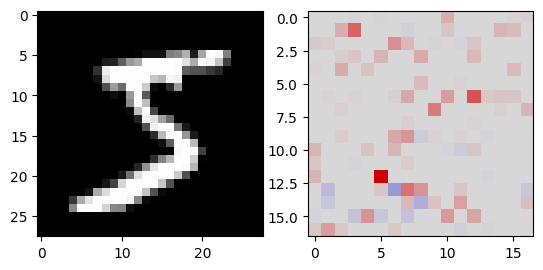

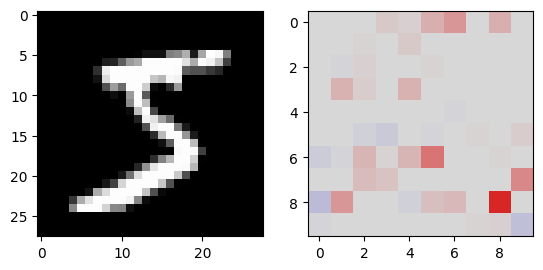

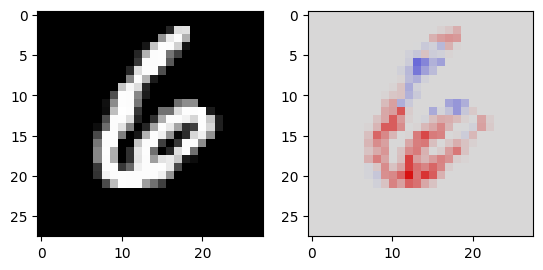

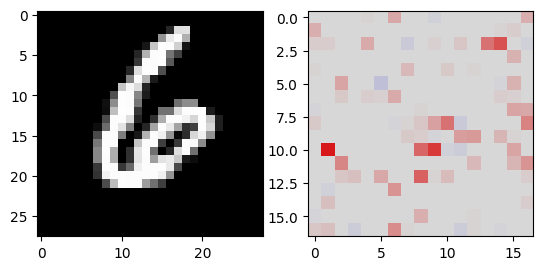

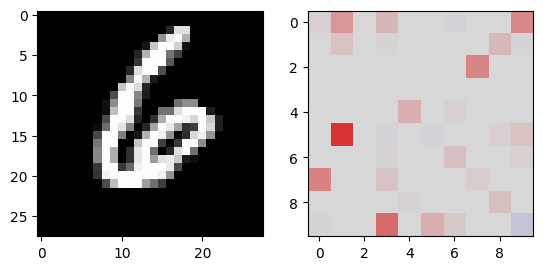

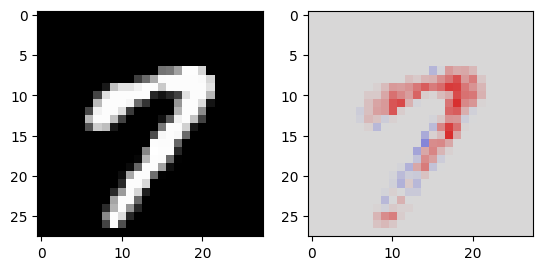

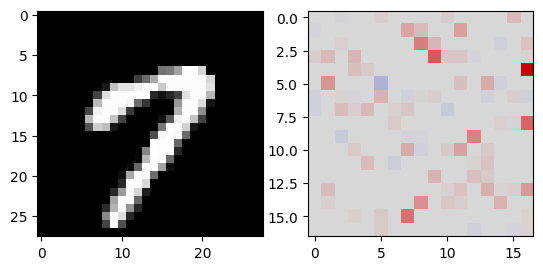

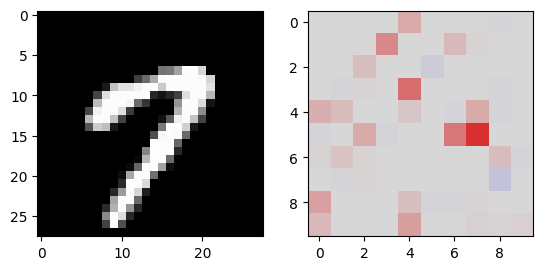

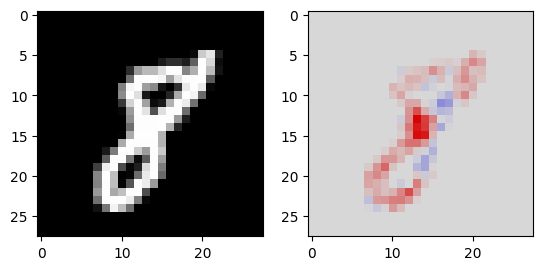

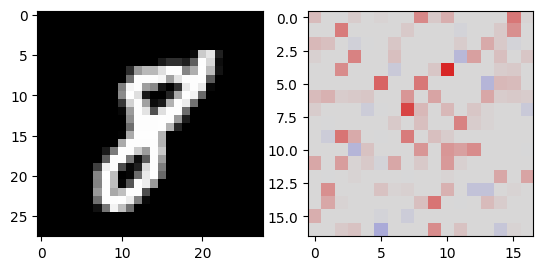

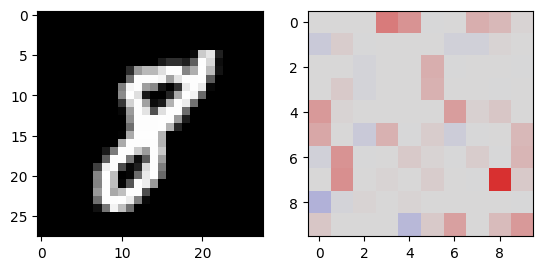

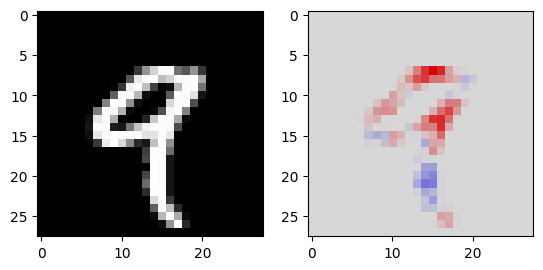

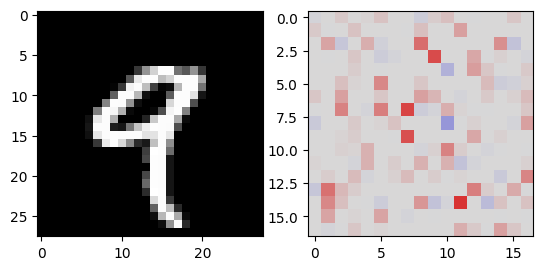

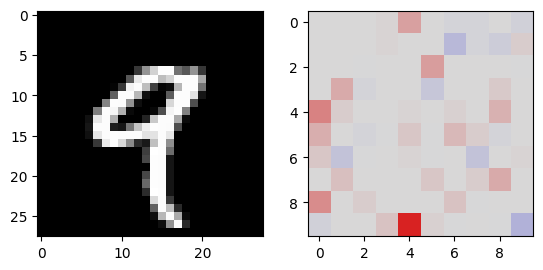

In [34]:
for i in range(10):
    for l in range(0, 3):
        sqrt = int(np.sqrt(R[l][T==i][0].shape[0]))
        image = R[l][T==i][0].reshape((sqrt, sqrt))

        b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

        my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
        my_cmap[:,0:3] *= 0.85
        my_cmap = ListedColormap(my_cmap)
        fig, axs = plt.subplots(1, 2)

        axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
        axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
        plt.show()

### 2.2 Applying a threshold to the heatmap

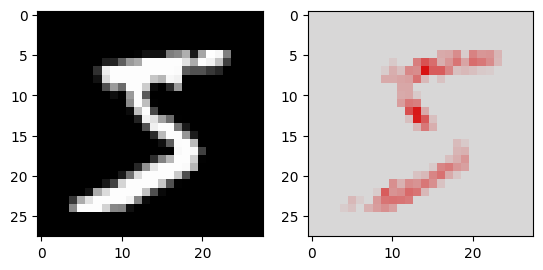

In [20]:
i = 0
image = R[0][i].reshape((28, 28))
threshold = 4
condition = image < threshold
image_t = np.copy(image)
image_t[condition] = np.zeros_like(image[condition])

b = 10*(np.abs(image_t)**3.0).mean()**(1.0/3)

my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
fig, axs = plt.subplots(1, 2)

axs[0].imshow(X[i].reshape((28, 28)), cmap="gray")
axs[1].imshow(image_t,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
plt.show()

### 2.3 Average relevance over class

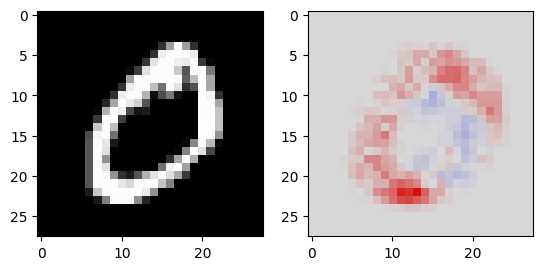

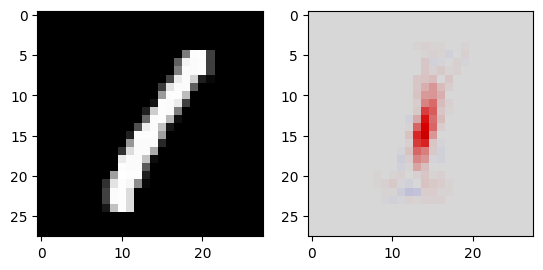

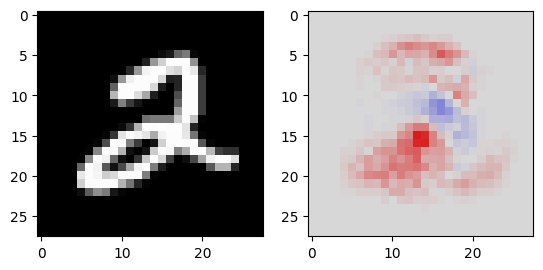

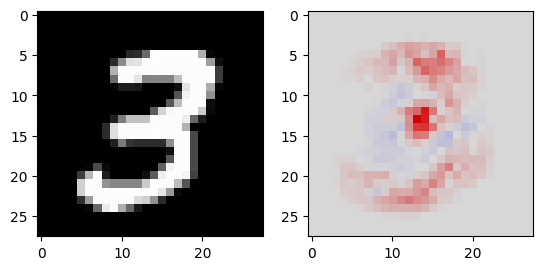

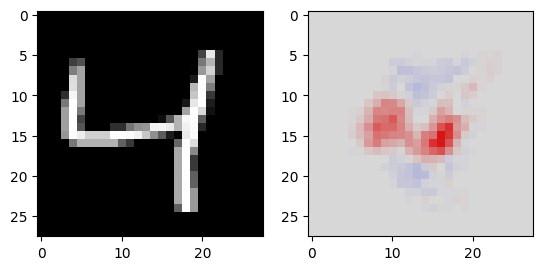

In [30]:
DIGITS = 5
for i in range(DIGITS):
    selected = R[0][T==i]
    image = selected.reshape((selected.shape[0], 28, 28))
    image = np.mean(image, axis=0)

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    plt.show()

## 3. Comparaison of LRP methods
### 3.1 LRP-0 vs Composite-LRP
Below, we use LRP-0 instead of Composite-LRP, and compare the two methods.

In [22]:
R_lrp0 = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

In [23]:
def rho_lrp0(w, _l):  return w
def incr_lrp0(z, _l): return z

In [24]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho_lrp0(W[l], l)
    b = incr_lrp0(B[l], l)

    z = incr_lrp0(A[l].dot(w)+b, l)
    s = R_lrp0[l+1] / z
    c = s.dot(w.T)
    R_lrp0[l] = A[l] * c

In [25]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_lrp0[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_lrp0[0] = A[0]*c - lb*cp - hb*cm

Average absolute relevance difference: 0.251
Normalized average absolute relevance difference: 0.73%


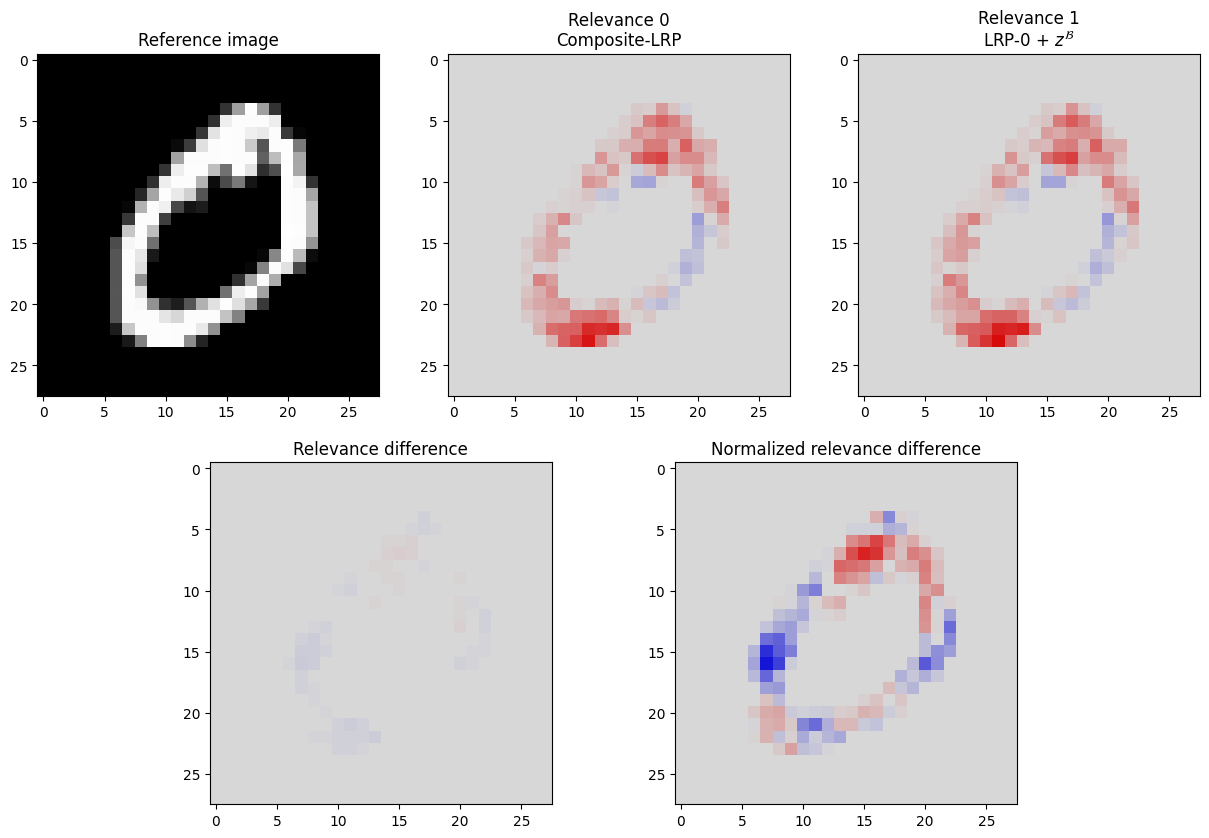

Average absolute relevance difference: 0.436
Normalized average absolute relevance difference: 1.34%


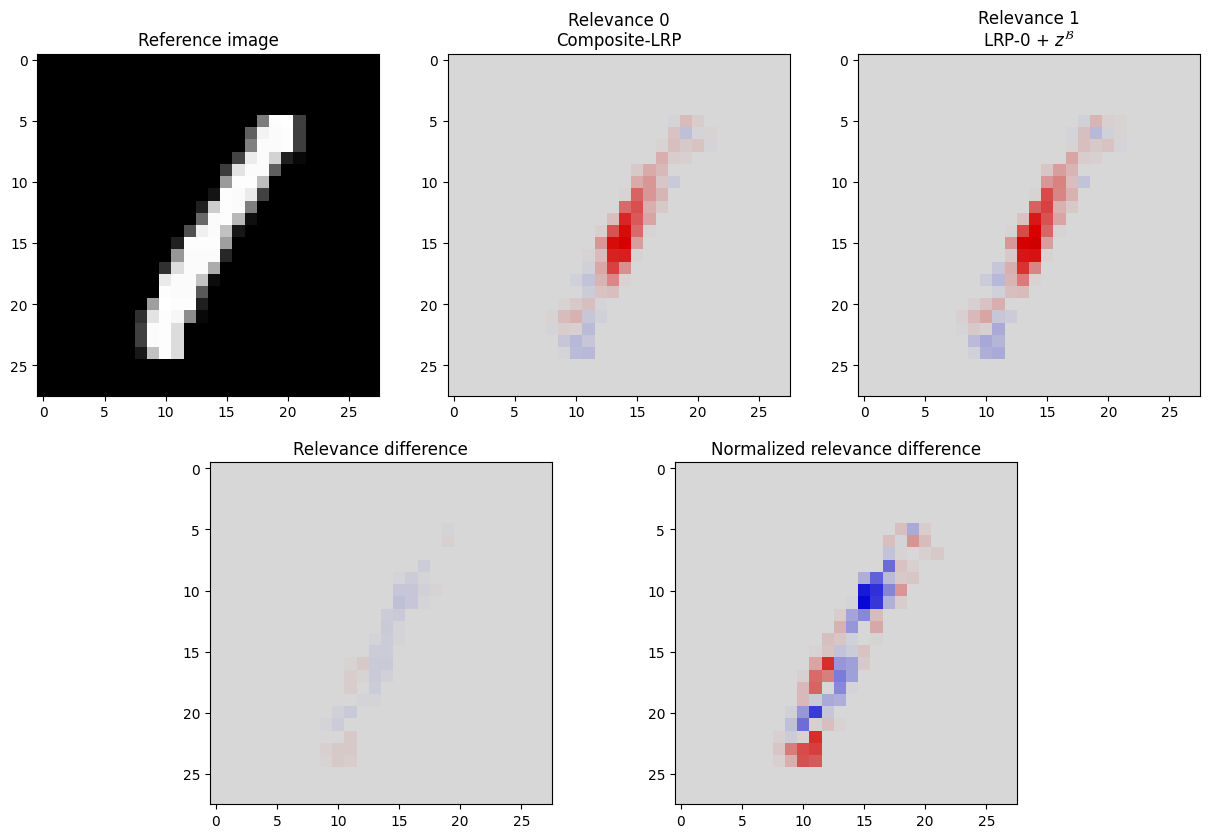

Average absolute relevance difference: 0.468
Normalized average absolute relevance difference: 1.38%


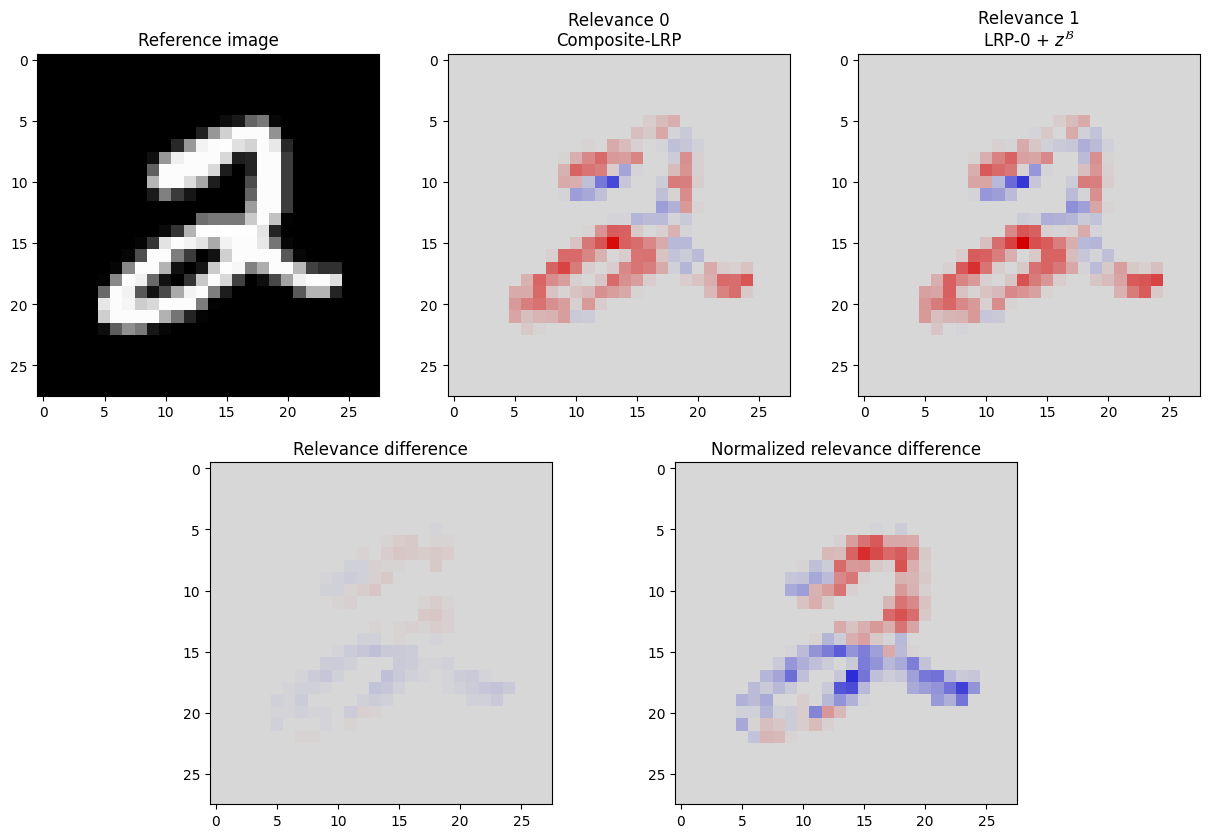

Average absolute relevance difference: 0.622
Normalized average absolute relevance difference: 1.29%


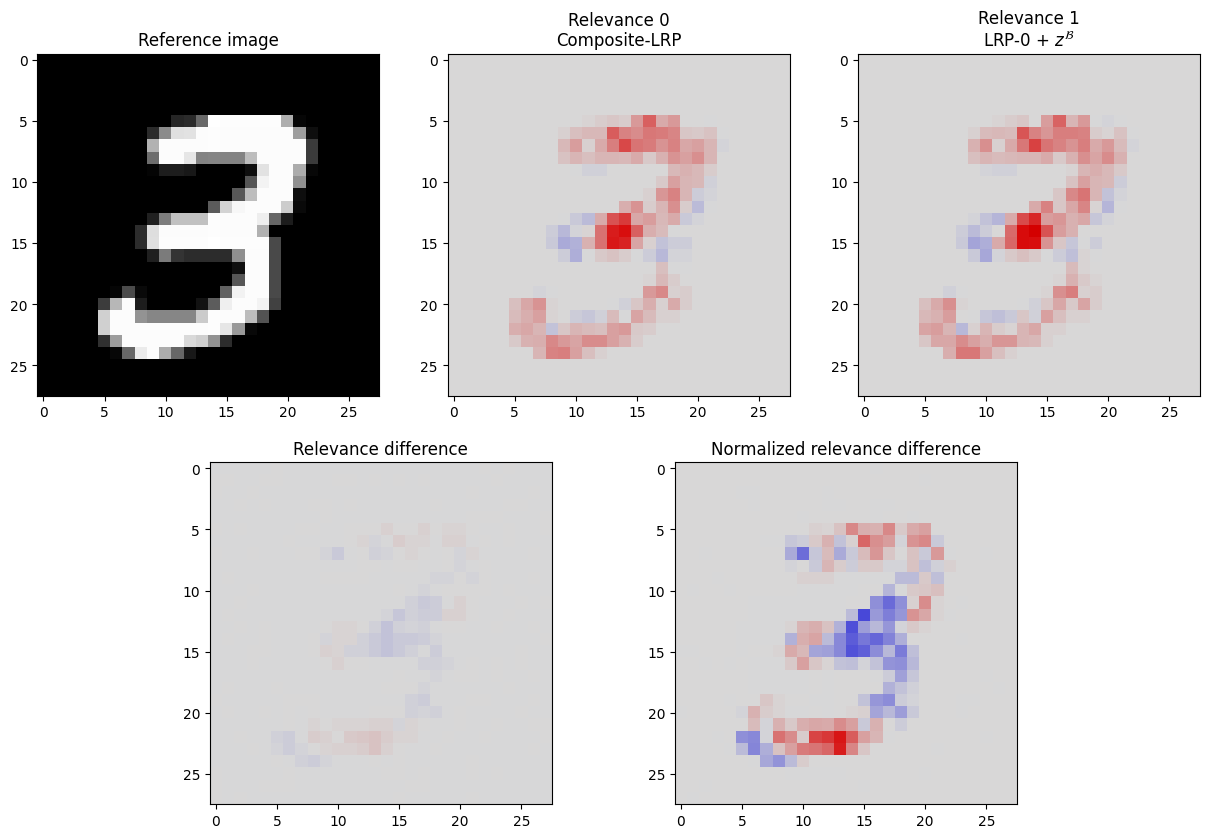

Average absolute relevance difference: 0.348
Normalized average absolute relevance difference: 1.68%


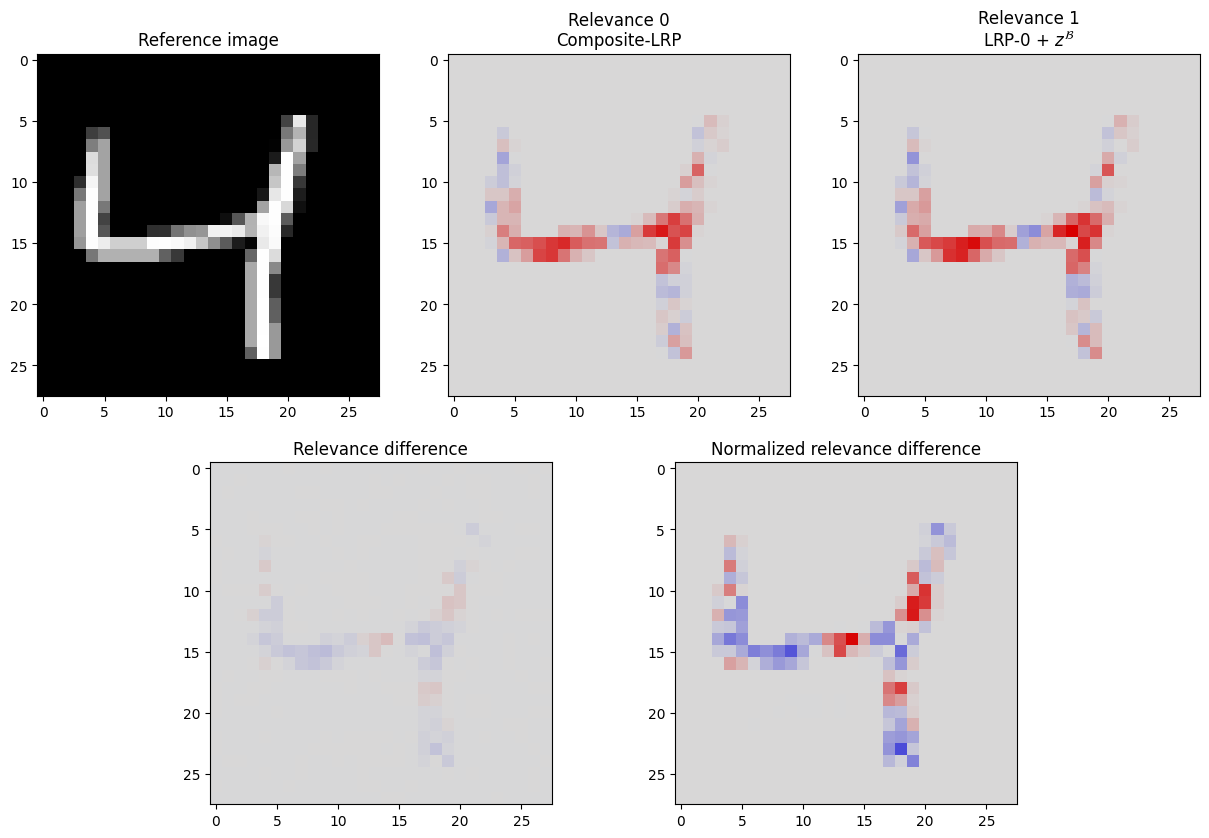

In [31]:
DIGITS = 5
for i in range(DIGITS):
    R_composite = R[0][T==i][0]
    R_0 = R_lrp0[0][T==i][0]

    reference = X[T==i][0]
    compare_relevance(reference, R_composite, R_0, shape=(28, 28), label0="Composite-LRP", label1="LRP-0 + $z^\\mathcal{B}$")

### 3.2 LRP-0 without $z^\mathcal{B}$ vs Composite-LRP

In [27]:
R_wozB = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

def rho_wozB(w, _l):  return w
def incr_wozB(z, _l): return z

In [28]:
# All layers even the pixels one
for l in range(0, L)[::-1]:
    w = rho_wozB(W[l], l)
    b = incr_wozB(B[l], l)

    z = incr_wozB(A[l].dot(w)+b, l)
    s = R_wozB[l+1] / z
    c = s.dot(w.T)
    R_wozB[l] = A[l] * c

Average absolute relevance difference: 0.789
Normalized average absolute relevance difference: 2.24%


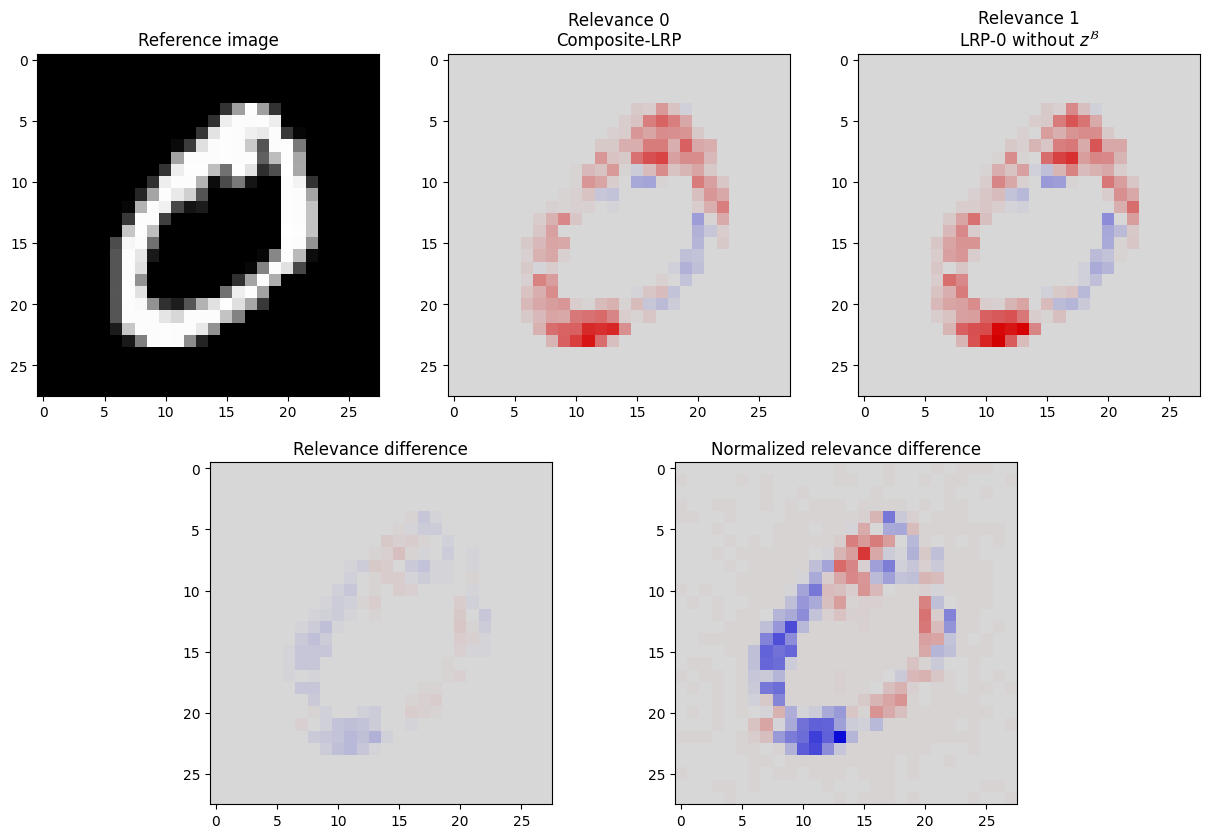

Average absolute relevance difference: 1.300
Normalized average absolute relevance difference: 3.76%


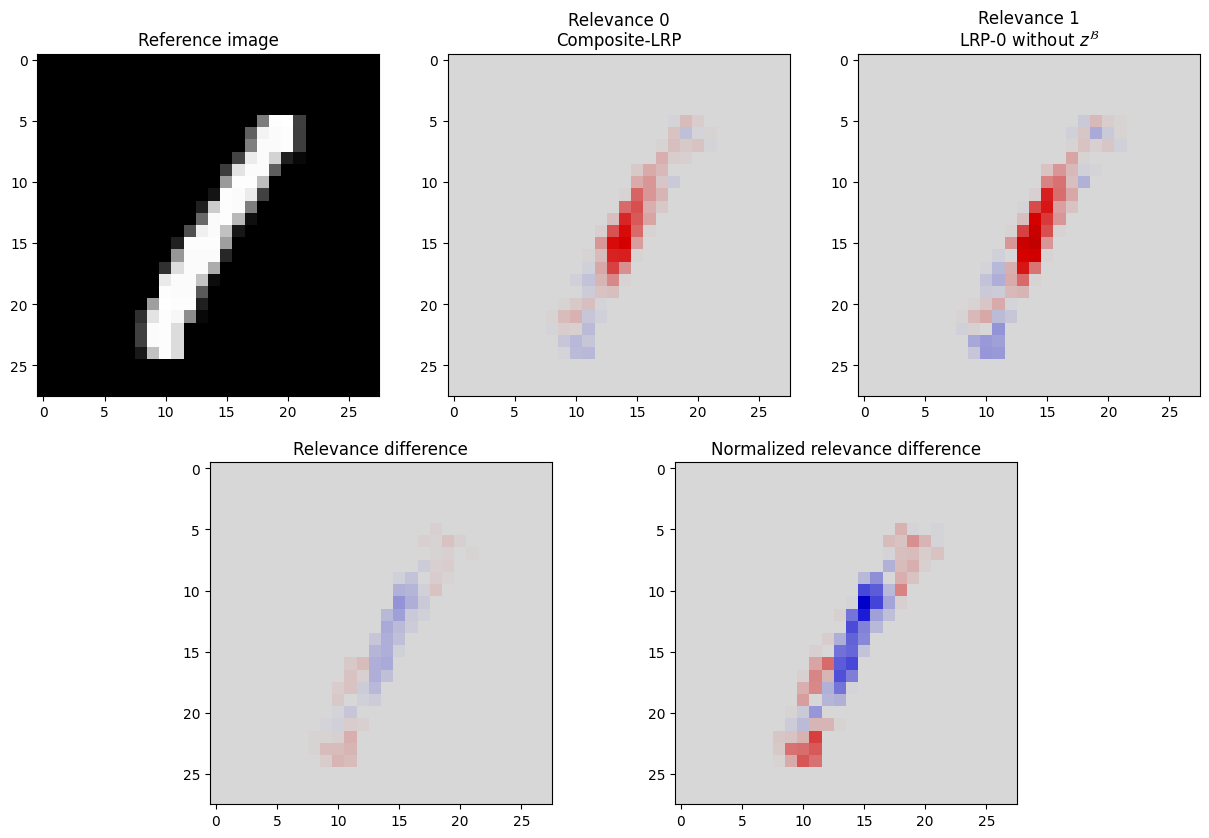

Average absolute relevance difference: 1.124
Normalized average absolute relevance difference: 3.13%


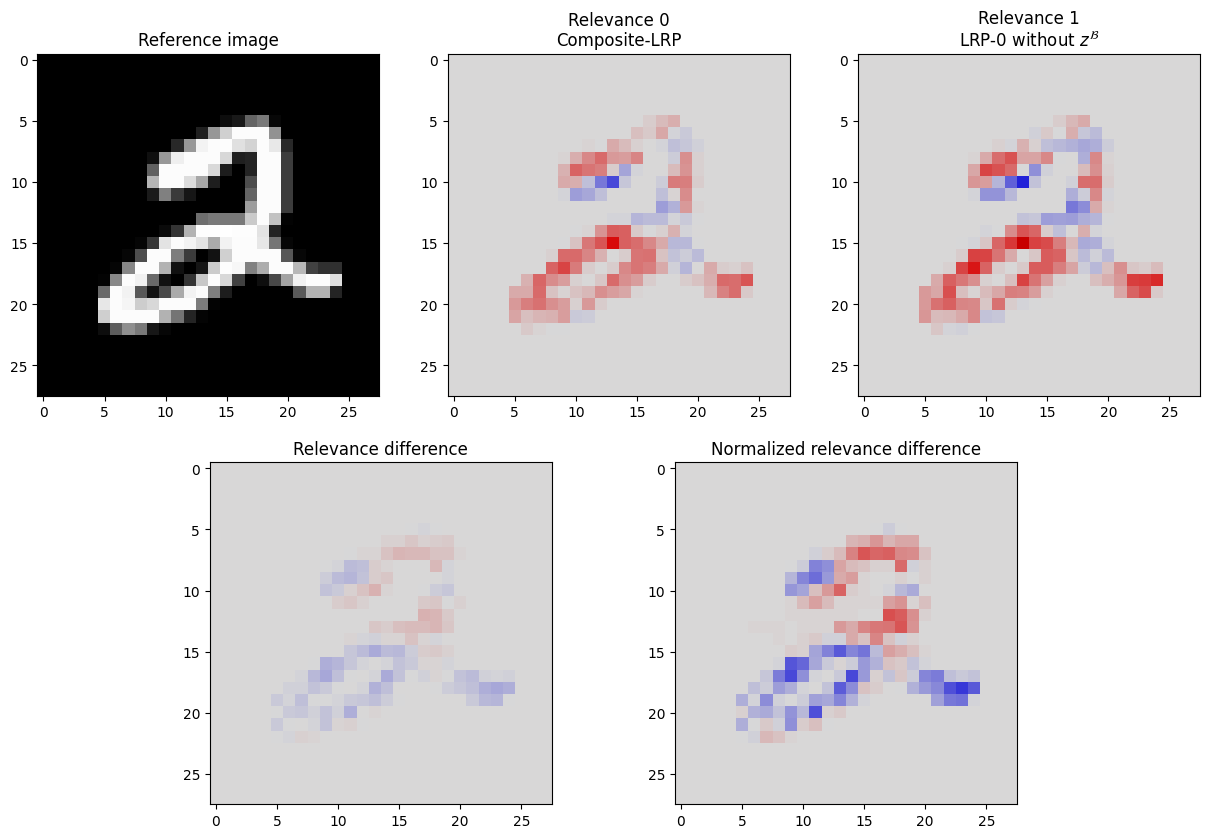

Average absolute relevance difference: 1.393
Normalized average absolute relevance difference: 2.83%


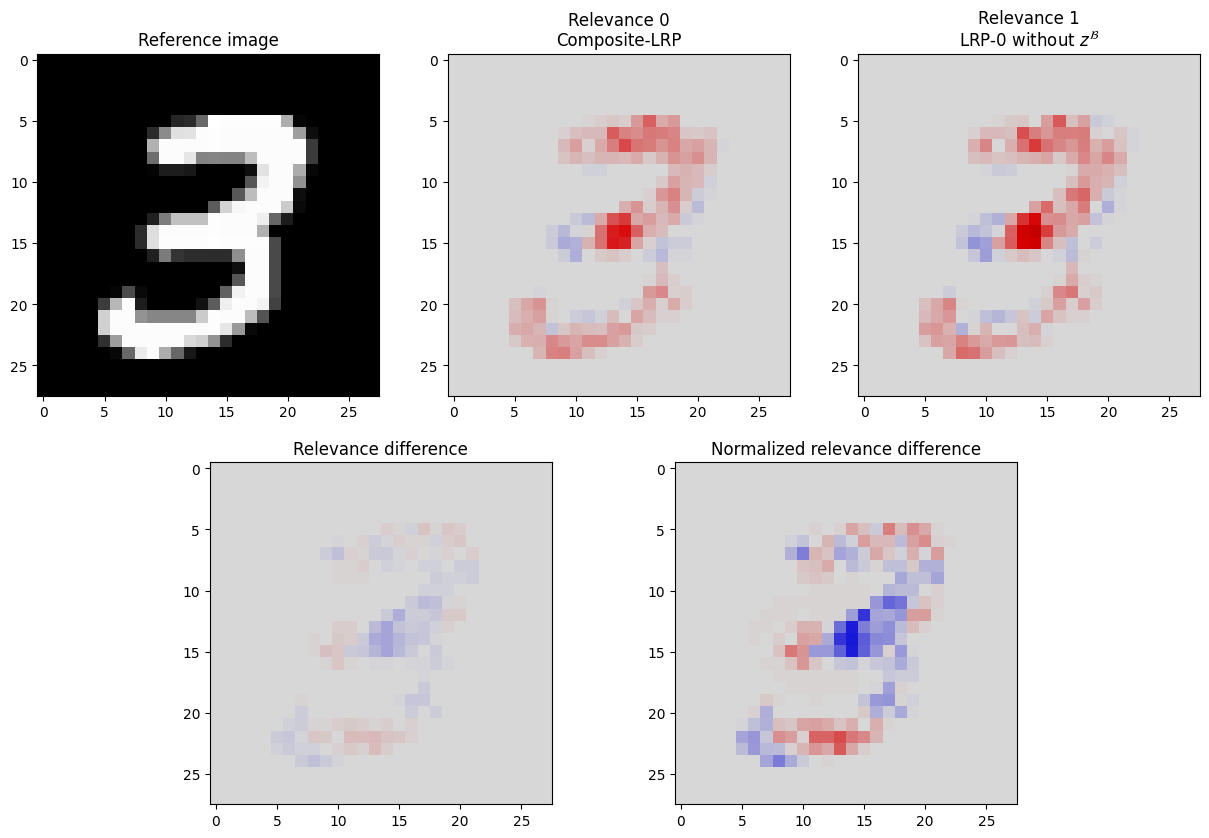

Average absolute relevance difference: 0.917
Normalized average absolute relevance difference: 4.17%


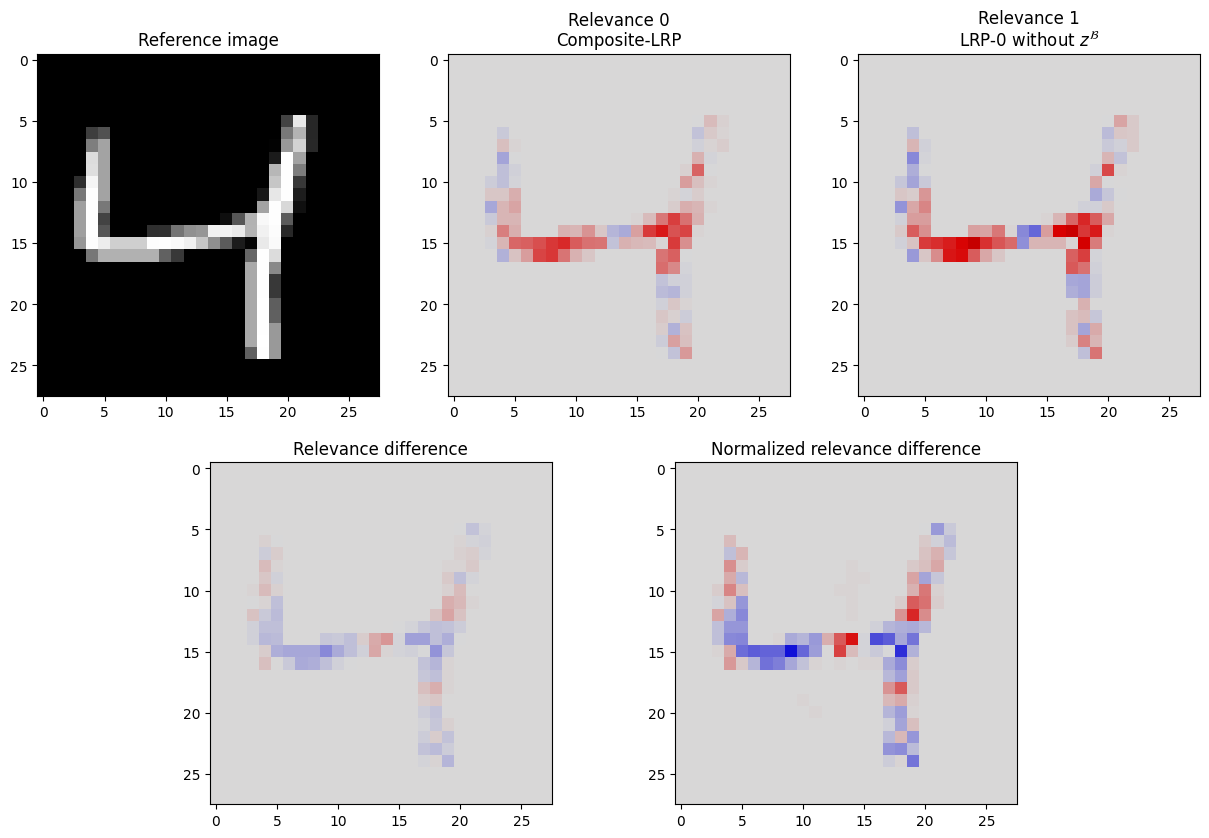

In [32]:
DIGITS = 5
for i in range(DIGITS):
    R_composite = R[0][T==i][0]
    R_0 = R_wozB[0][T==i][0]

    reference = X[T==i][0]
    compare_relevance(reference, R_composite, R_0, shape=(28, 28), label0="Composite-LRP", label1="LRP-0 without $z^\\mathcal{B}$")